In [295]:
import warnings
import numpy as np
import pandas as pd
import pprint
from datetime import datetime
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite

from sklearn.preprocessing import minmax_scale

from tqdm.notebook import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
ROOT_DATA = 'D:/Statistical Programming Projects/Social Network and Sentiment Analysis/data/'

In [291]:
covid_tweets = pd.read_csv(ROOT_DATA+"02_covid_with_sentiments.csv")
covid_tweets = covid_tweets[~covid_tweets.timestamp.isnull()]
covid_tweets = covid_tweets[~covid_tweets.KeyTopic.isnull()]
covid_tweets.reset_index(drop=True,inplace=True)
covid_tweets.drop(['Unnamed: 0'],inplace=True,axis=1)
covid_tweets.tweeter_handle = covid_tweets.tweeter_handle.astype(str)
scaler = MinMaxScaler()
covid_tweets['init_reach_scaled'] = minmax_scale(covid_tweets.init_reach.values, feature_range=(0.1,1))
covid_tweets['likes_scaled'] = minmax_scale(covid_tweets.likes.values, feature_range=(0.1,1))
covid_tweets.init_reach[covid_tweets.init_reach_scaled > 0.1001138] = 10000
covid_tweets.tail(5)

id  tweeter_handle  init_reach            timestamp  \
48438  1.251370e+18         CBSNews     10000.0  2020-04-18 04:39:56   
48439  1.251364e+18   IndianExpress     10000.0  2020-04-18 04:15:03   
48440  1.251330e+18  cionmerchsales         6.0  2020-04-18 02:03:10   
48441  1.251327e+18     Masratzahra     10000.0  2020-04-18 01:50:28   
48442  1.251307e+18    JasonWhitely     10000.0  2020-04-18 00:28:36   

                                              orig_tweet  likes  retweets  \
48438  Facebook will now warn users who "like" fake c...  369.0     104.0   
48439  #CoronavirusPandemic LIVE updates  |  \r\n*Glo...   87.0      21.0   
48440  **RTs APPRECIATED**\r\n[Group Order] IveSta Ep...    1.0       4.0   
48441  People offer Friday prayers at Thanavi Mosque ...  659.0      57.0   
48442  INCREDIBLE: Ruth’s Chris Steakhouse, with 5K e...   76.0      58.0   

                  hashtags mentions            location  retweeted  reply  \
48438                  NaN      NaN        New York, NY        NaN    NaN   
48439  CoronavirusPandemic      NaN               India        NaN    NaN   
48440                  NaN      NaN                 NaN        NaN    NaN   
48441                  NaN      NaN  Srinagar,Kashmir.         NaN    NaN   
48442                  NaN      NaN   Dallas/Fort Worth        NaN    NaN   

                                        simplified_tweet  \
48438  Facebook will now warn users who "like" fake c...   
48439  CoronavirusPandemic LIVE updates *Globally, to...   
48440  **RTs APPRECIATED** [Group Order] IveSta Ep. G...   
48441  People offer Friday prayers at Thanavi Mosque ...   
48442  INCREDIBLE: Ruth’s Chris Steakhouse, with  emp...   

                                     KeyTopic  \
48438  WebinarJoinLiveRegisterImpactWorkLearn   
48439         CasesPeopleDiedDetailGlobalNeed   
48440                  ReportTestStaySafeWork   
48441         CasesPeopleDiedDetailGlobalNeed   
48442           GetPublicWorkerDeathsOutbreak   

                                             clean_tweet  Sentiments  Day  \
48438  Facebook will now warn users who "like" fake c...     -0.5994  109   
48439  #CoronavirusPandemic LIVE updates  |  \r *Glob...      0.7177  109   
48440  **RTs APPRECIATED**\r [Group Order] IveSta Ep....      0.0258  109   
48441  People offer Friday prayers at Thanavi Mosque ...      0.0000  109   
48442  INCREDIBLE: Ruth’s Chris Steakhouse, with 5K e...      0.2960  109   

       Hour  init_reach_scaled  likes_scaled  
48438     4           0.185808      0.100996  
48439     4           0.139761      0.100235  
48440     2           0.100000      0.100003  
48441     1           0.100374      0.101778  
48442     0           0.100331      0.100205

In [364]:
G = nx.DiGraph()
uG = nx.Graph()

for idx,row in tqdm(covid_tweets.iterrows(),total=covid_tweets.shape[0]):
    
    #for idx,row in covid_tweets.head(1000).iterrows():
    if not(pd.isnull(row["retweeted"])):        
        
        try:
            retweeted = covid_tweets.tweeter_handle[covid_tweets.id == int(row["retweeted"])].values[0]
            retweet_followers = covid_tweets.init_reach[covid_tweets.id == int(row["retweeted"])].values[0]
            retweeted_likes = covid_tweets.likes[covid_tweets.id == int(row["retweeted"])].values[0]
            orig_timestamp= covid_tweets.timestamp[covid_tweets.id == int(row["retweeted"])]
        except:
            continue #retweeted tweet not in current dataset
        
        rt_timestamp = datetime.strptime(row['timestamp'],'%Y-%m-%d %H:%M:%S')
        
        if not G.has_node(row["tweeter_handle"]):                       
            G.add_node(row["tweeter_handle"],audience=int(row['init_reach']))
            
        if not G.has_node(retweeted): 
            G.add_node(retweeted,audience=int(retweet_followers))
        
        G.add_edge(
            row["tweeter_handle"],
            retweeted,
            dateOrig = orig_timestamp, 
            dateRt = rt_timestamp,
            topic = row['KeyTopic'],
            sentiment = row['Sentiments'],
            weight=retweeted_likes+1
        )
        
        '''
        uG.add_edge(
            retweeted,
            str(row["tweeter_handle"].values[0]),
            dateOrig = orig_timestamp, 
            dateRt = rt_timestamp,
            topic = row['KeyTopic'].values[0],
            sentiment = float(row['Sentiments'].values[0])
        )
        '''

#tqdm.pandas()
#done = covid_tweets.head(1000).progress_apply(create_graph,axis=1)

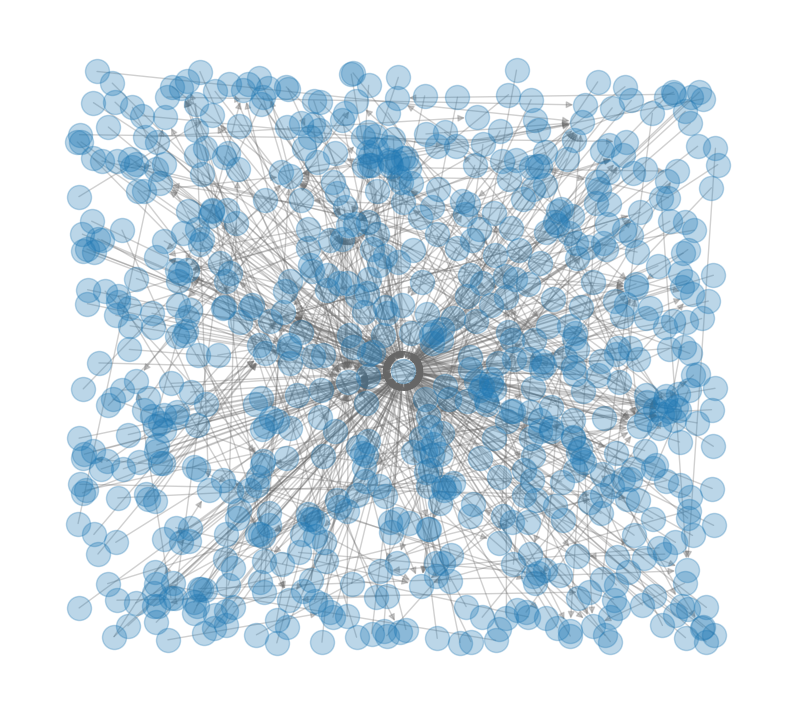

In [296]:
plt.figure(figsize=(10,9))
mpl.rcParams.update(mpl.rcParamsDefault)
pos = nx.random_layout(G)
nx.draw_networkx(G, pos, alpha=0.3, with_labels=False, edge_color='.4')
plt.axis('off')
plt.show()

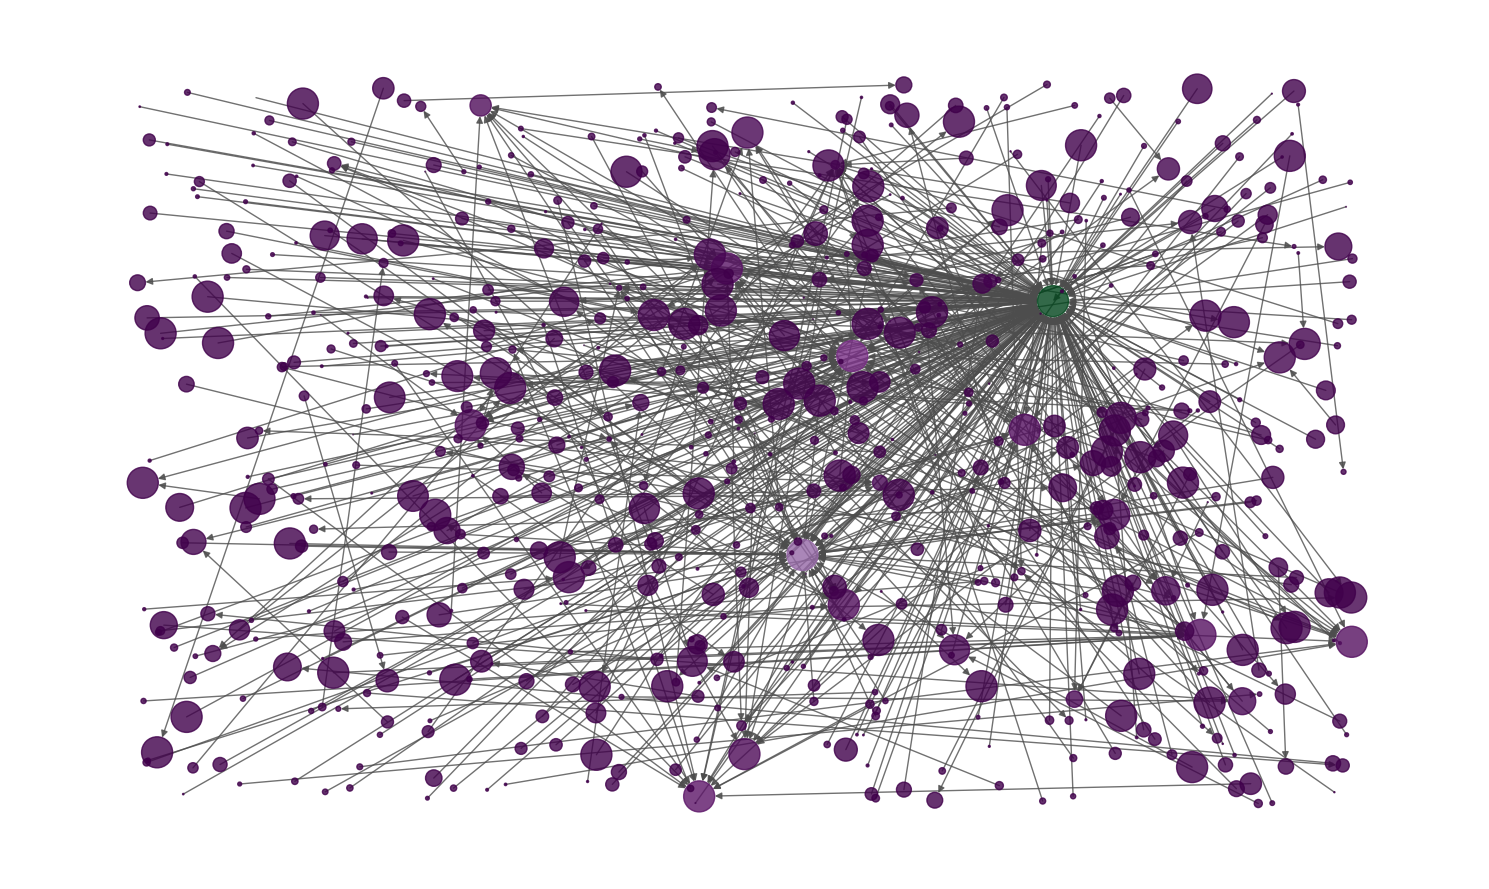

In [320]:
options = {
    'node_color': '#999999',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.style.use('default')
plt.figure(figsize=(15,9))
pos = nx.random_layout(G)

edge_colourmap = dict(zip(covid_tweets.KeyTopic.unique().tolist(),sns.color_palette("bright", 7).as_hex()))

node_color = [G.degree(v) for v in G]
node_size = [0.05*nx.get_node_attributes(G, 'audience')[v] for v in G]
edge_width = [0.0015*G[u][v]['weight'] for u,v in G.edges()]
edge_colours = [edge_colourmap[G[u][v]['topic']] for u,v in G.edges()]

nx.draw_networkx(G, pos, 
                 node_size=node_size, 
                 node_color=node_color, alpha=0.8, with_labels=False, 
                 #width=edge_width, 
                 edge_color='.3', cmap=plt.cm.PRGn)

plt.axis('off')
plt.tight_layout();

#nx.draw(G,**options)

## Bipartite graph (item-user collaborative filtering)

In [323]:
BG = nx.Graph()
BG.add_nodes_from(covid_tweets.head(1000).tweeter_handle.unique().tolist(),bipartite=0)
BG.add_nodes_from(covid_tweets.head(1000).KeyTopic.unique().tolist(),bipartite=1)
for idx,row in covid_tweets.head(1000).iterrows():    
    BG.add_edge(
        row["tweeter_handle"],
        row["KeyTopic"],
        weight = row["retweets"] + 1, #Incase there are no retweets.
        sentiments = row["Sentiments"]
    )   

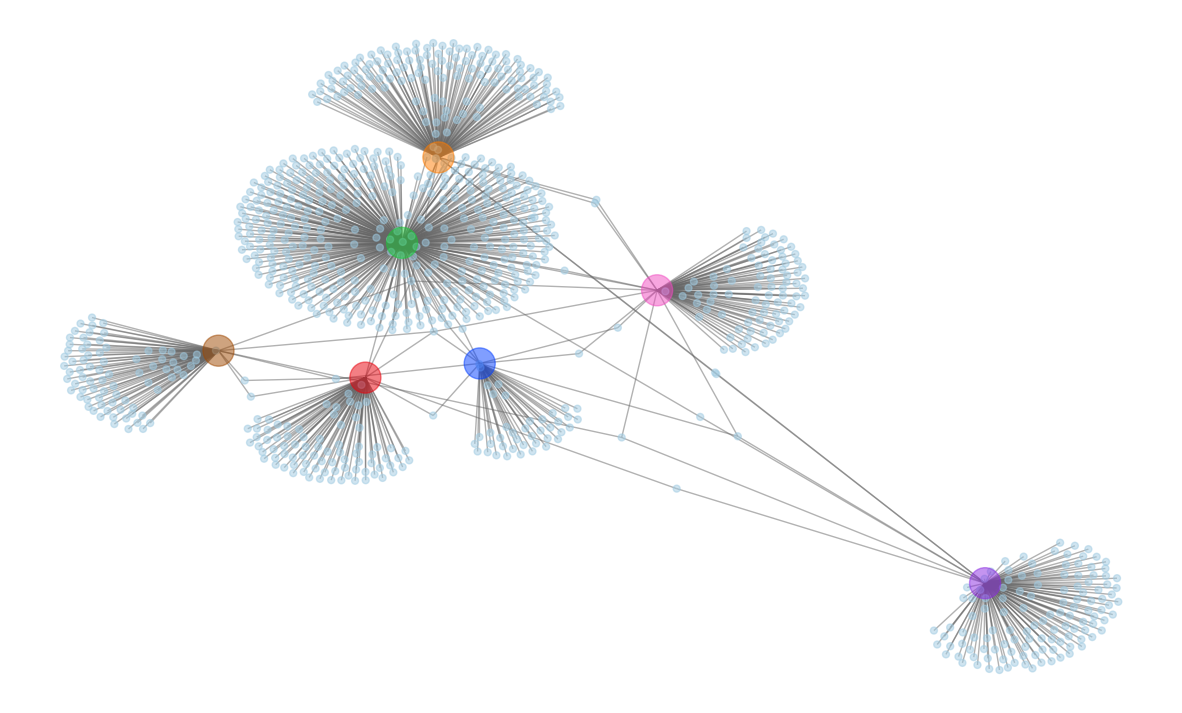

In [349]:
plt.figure(figsize=(15,9))
pos = nx.spring_layout(BG)

edge_colourmap = dict(zip(covid_tweets.KeyTopic.unique().tolist(),sns.color_palette("bright", 7).as_hex()))
node_colors = [edge_colourmap[v] if v in edge_colourmap else '#A0CBE2' for v in BG]
node_sizes = [500 if v in edge_colourmap else 25 for v in BG]

nx.draw_networkx(BG,pos,
                 alpha=0.5,
                 node_size=node_sizes,
                 node_color=node_colors,
                 with_labels=False,
                 edge_color='.4'
                )
plt.axis('off')
plt.show()
#nx.draw(BG,**options,with_labels = False)

## Projected graph (User-User collaborative filtering)

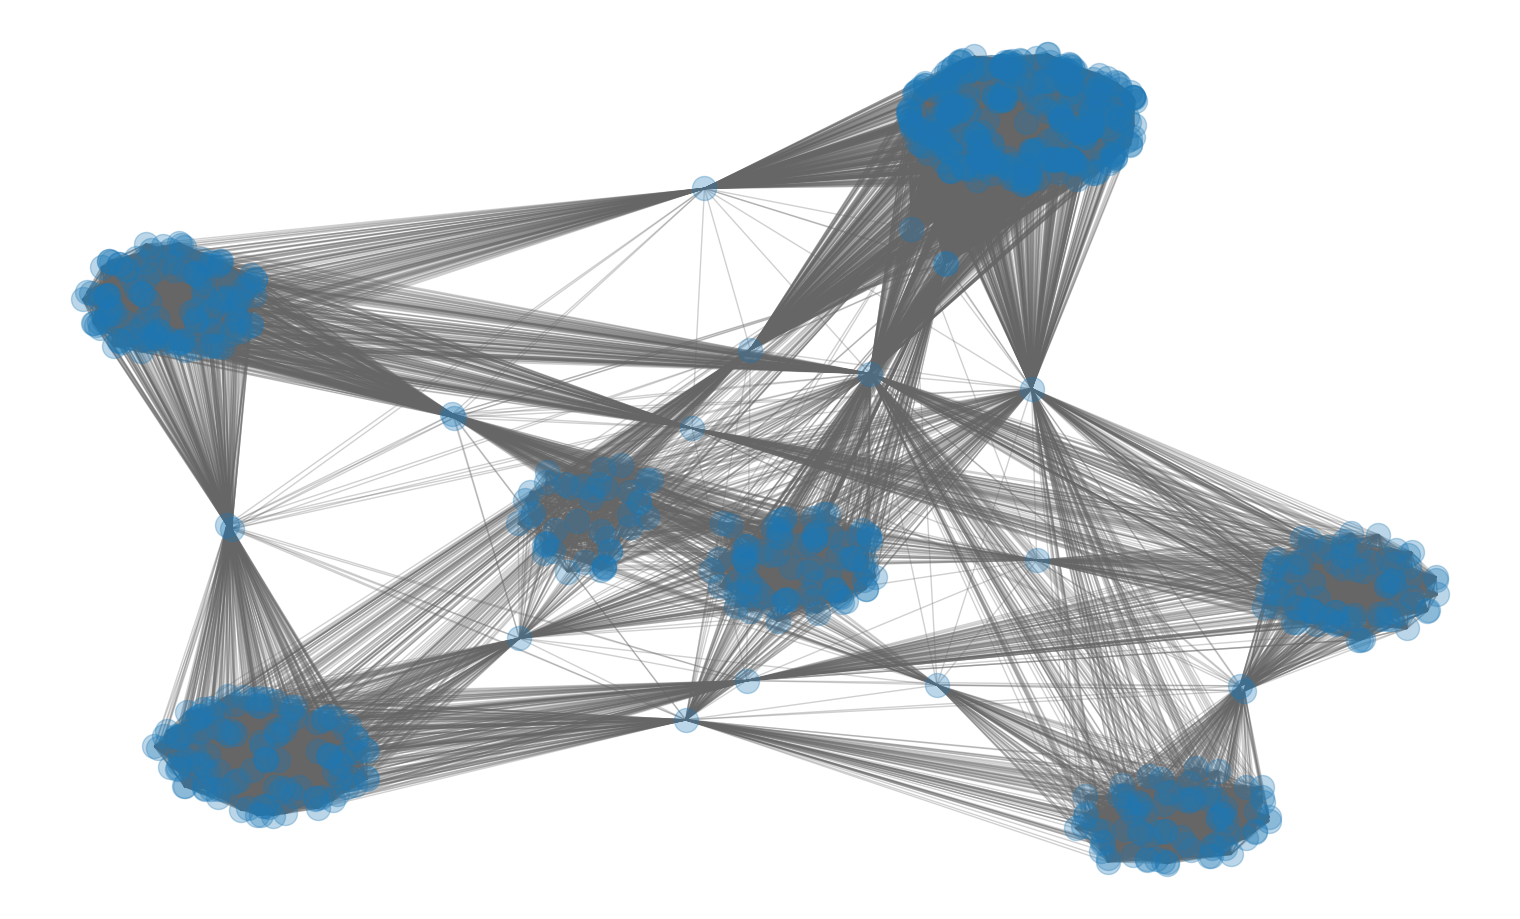

In [365]:
plt.figure(figsize=(15,9))
PG = bipartite.weighted_projected_graph(BG,covid_tweets.head(1000).tweeter_handle.unique().tolist())
nx.draw(PG,pos=nx.spring_layout(PG),
        edge_color='.4',
        alpha=0.3,
        with_labels = False)

## Distance

In [359]:
if not nx.is_weakly_connected(G):
    print("Strongly connected components: {}({:.2%})".format(
        nx.number_strongly_connected_components(G),
        nx.number_strongly_connected_components(G)/(nx.number_weakly_connected_components(G)+
                                                    nx.number_strongly_connected_components(G))
    ))
    tweakedG = G.subgraph(sorted(nx.strongly_connected_components(G),key=len, reverse=True)[0])
else:
    tweakedG = G
    
#nx.draw(tweakedG,**options,pos=nx.spring_layout(tweakedG),with_labels = False)

Strongly connected components: 700(86.00%)


In [360]:
print("Tweet Radius: {:.3f}".format(nx.radius(tweakedG)))
print("Tweet Diameter: {:.3f}".format(nx.diameter(tweakedG)))
print("Tweet Average Distance: {:.3f}".format(nx.average_shortest_path_length(tweakedG)))
print("Twerps in the Centre: {}({:.2%})".format(len(nx.center(tweakedG)),
                                                   len(nx.center(tweakedG))/nx.number_of_nodes(tweakedG)))
print("Twerps in the Periphery: {}({:.2%})".format(len(nx.periphery(tweakedG)),
                                                   len(nx.periphery(tweakedG))/nx.number_of_nodes(tweakedG)))

Tweet Radius: 1.000
Tweet Diameter: 1.000
Tweet Average Distance: 1.000
Twerps in the Centre: 2(100.00%)
Twerps in the Periphery: 2(100.00%)


## Centrality

### Degree Centrality

_Assumption_ : Important Nodes have highest number of connections (neighbours)

In [160]:
degCent = nx.degree_centrality(G)
degCent = {k: v for k, v in sorted(degCent.items(), key=lambda item: item[1],reverse=True)}
degrees = set([item[1] for item in degCent.items()])
print("Degrees in the SNA are {}".format(len(degrees)))

Degrees in the SNA are 40


In [161]:
topFive = sorted(degrees,reverse=True)[0:5] #5 topmost degrees
degCentTop5 = {(v,k) for k,v in degCent.items() if v in topFive}
pprint.pprint(degCentTop5)

degCentTop5 = [k[0] for k in degCentTop5]
Counter(degCentTop5)

{(0.005871517384296569, 'NzBlackcaps'),
 (0.006447156343541331, 'BBCNews'),
 (0.006562284135390283, 'Narc_Problems'),
 (0.006677411927239235, 'WHO'),
 (0.020147363573566657, 'realDonaldTrump')}


Counter({0.005871517384296569: 1,
         0.006562284135390283: 1,
         0.020147363573566657: 1,
         0.006677411927239235: 1,
         0.006447156343541331: 1})

In [182]:
inDegCent = nx.in_degree_centrality(G)
inDegCent = {k: v for k, v in sorted(inDegCent.items(), key=lambda item: item[1],reverse=True)}
degrees = set([item[1] for item in inDegCent.items()])
print("Degrees in the SNA are {}".format(len(degrees)))

Degrees in the SNA are 32


In [183]:
topFive = sorted(degrees,reverse=True)[0:5] #5 topmost degrees
degCentTop5 = {(v,k) for k,v in inDegCent.items() if v in topFive}
pprint.pprint(degCentTop5)

degCentTop5 = [k[0] for k in degCentTop5]
Counter(degCentTop5)

{(0.004720239465807046, 'GovWhitmer'),
 (0.005526134008749712, 'MoHFW_INDIA'),
 (0.006447156343541331, 'BBCNews'),
 (0.006677411927239235, 'WHO'),
 (0.020147363573566657, 'realDonaldTrump')}


Counter({0.005526134008749712: 1,
         0.020147363573566657: 1,
         0.006677411927239235: 1,
         0.006447156343541331: 1,
         0.004720239465807046: 1})

### Closeness centrality

_Assumption_ : Important nodes are close to other nodes

In [163]:
closeCent = nx.closeness_centrality(G,wf_improved=True)
closeCent = {k: v for k, v in sorted(closeCent.items(), key=lambda item: item[1],reverse=True)}
degrees = set([item[1] for item in closeCent.items()])
print("Degrees in the SNA are {}".format(len(degrees)))

Degrees in the SNA are 93


In [166]:
topFive = sorted(degrees,reverse=True)[0:5] #5 topmost degrees
closeCentTop5 = {(v,k) for k,v in closeCent.items() if v in topFive}
pprint.pprint(closeCentTop5)

closeCentTop5 = [k[1].strip() for k in closeCentTop5]
Counter(closeCentTop5)

{(0.004571250558708401, 'GovWhitmer'),
 (0.0056412618005986645, 'MoHFW_INDIA'),
 (0.006447156343541331, 'BBCNews'),
 (0.0067495322106388665, 'WHO'),
 (0.02017721151960157, 'realDonaldTrump')}


Counter({'realDonaldTrump': 1,
         'GovWhitmer': 1,
         'BBCNews': 1,
         'WHO': 1,
         'MoHFW_INDIA': 1})